In [1]:
import pandas as pd
import numpy as np
from phik.report import plot_correlation_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

pd.options.display.float_format = '{:.4f}'.format

2024-08-29 18:39:11.103608: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 18:39:11.297620: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 18:39:11.556965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 18:39:11.721624: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 18:39:11.771076: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 18:39:12.155382: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# Пропусков нет, категориальных переменных тоже
df = pd.read_csv('train_3.2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

In [3]:
df.drop('id', axis=1, inplace=True)
display(df.describe(percentiles=[.25, .5, .75, .95]).loc[:, :'e'])
df.describe(percentiles=[.25, .5, .75, .95]).loc[:, 'e':]


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e
count,101763.0000,101763.0000,101763.0000,101763.0000,101763.0000,101763.0000,101763.0000,101763.0000,101763.0000,101763.0000
mean,37.3472,5.4927,2.8450,3.4988,96.6560,538.2810,0.1116,13.6819,27.5730,20853.5899
std,54.6004,7.9009,4.6313,5.5345,171.1472,1270.7916,0.1001,14.1213,22.8567,190571.4054
min,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,13.0000,2.0000,1.0000,1.0000,25.0000,97.6700,0.0500,5.6000,15.5600,564.7300
50%,22.0000,3.0000,1.0000,2.0000,51.0000,232.7900,0.0900,9.8200,23.3600,2256.2300
75%,42.0000,6.0000,3.0000,4.0000,111.0000,560.2500,0.1500,18.0000,34.3400,10193.2400
95%,113.0000,17.0000,11.0000,10.0000,312.0000,1812.5910,0.3200,37.7300,61.9000,65221.5000
max,3442.0000,404.0000,165.0000,402.0000,8441.0000,80843.0800,1.0000,418.2000,569.7800,16846621.1200


,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,101763.0000,101763.0000,101763.0000,101763.0000,101763.0000,101763.0000,101763.0000,101763.0000,101763.0000,101763.0000,101763.0000,101763.0000
mean,20853.5899,0.1792,1141.3580,22.8025,1.7739,3.9799,0.1966,11.8961,15.5967,57.6281,39.2497,9.8395
std,190571.4054,0.4218,9862.7955,38.5410,5.9024,6.3824,0.9989,6.7495,18.0643,104.5377,71.6923,14.4128
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
25%,564.7300,0.0300,31.3800,7.0000,0.0000,1.0000,0.0000,8.0000,7.0000,15.0000,10.0000,3.0000
50%,2256.2300,0.0800,125.4000,14.0000,0.0000,2.0000,0.0000,11.0000,12.0000,30.0000,20.0000,5.0000
75%,10193.2400,0.1900,565.9200,26.0000,1.0000,5.0000,0.0000,16.0000,20.0000,66.0000,45.0000,11.0000
95%,65221.5000,0.6000,3623.4200,71.0000,9.0000,13.0000,1.0000,23.0000,42.0000,183.0000,129.0000,33.0000
max,16846621.1200,26.9500,935923.3900,2824.0000,344.0000,219.0000,43.0000,410.0000,1026.0000,5420.0000,3021.0000,503.0000


array([[<Axes: title={'center': 'loc'}>,
        <Axes: title={'center': 'v(g)'}>],
       [<Axes: title={'center': 'ev(g)'}>,
        <Axes: title={'center': 'iv(g)'}>],
       [<Axes: title={'center': 'n'}>, <Axes: >]], dtype=object)

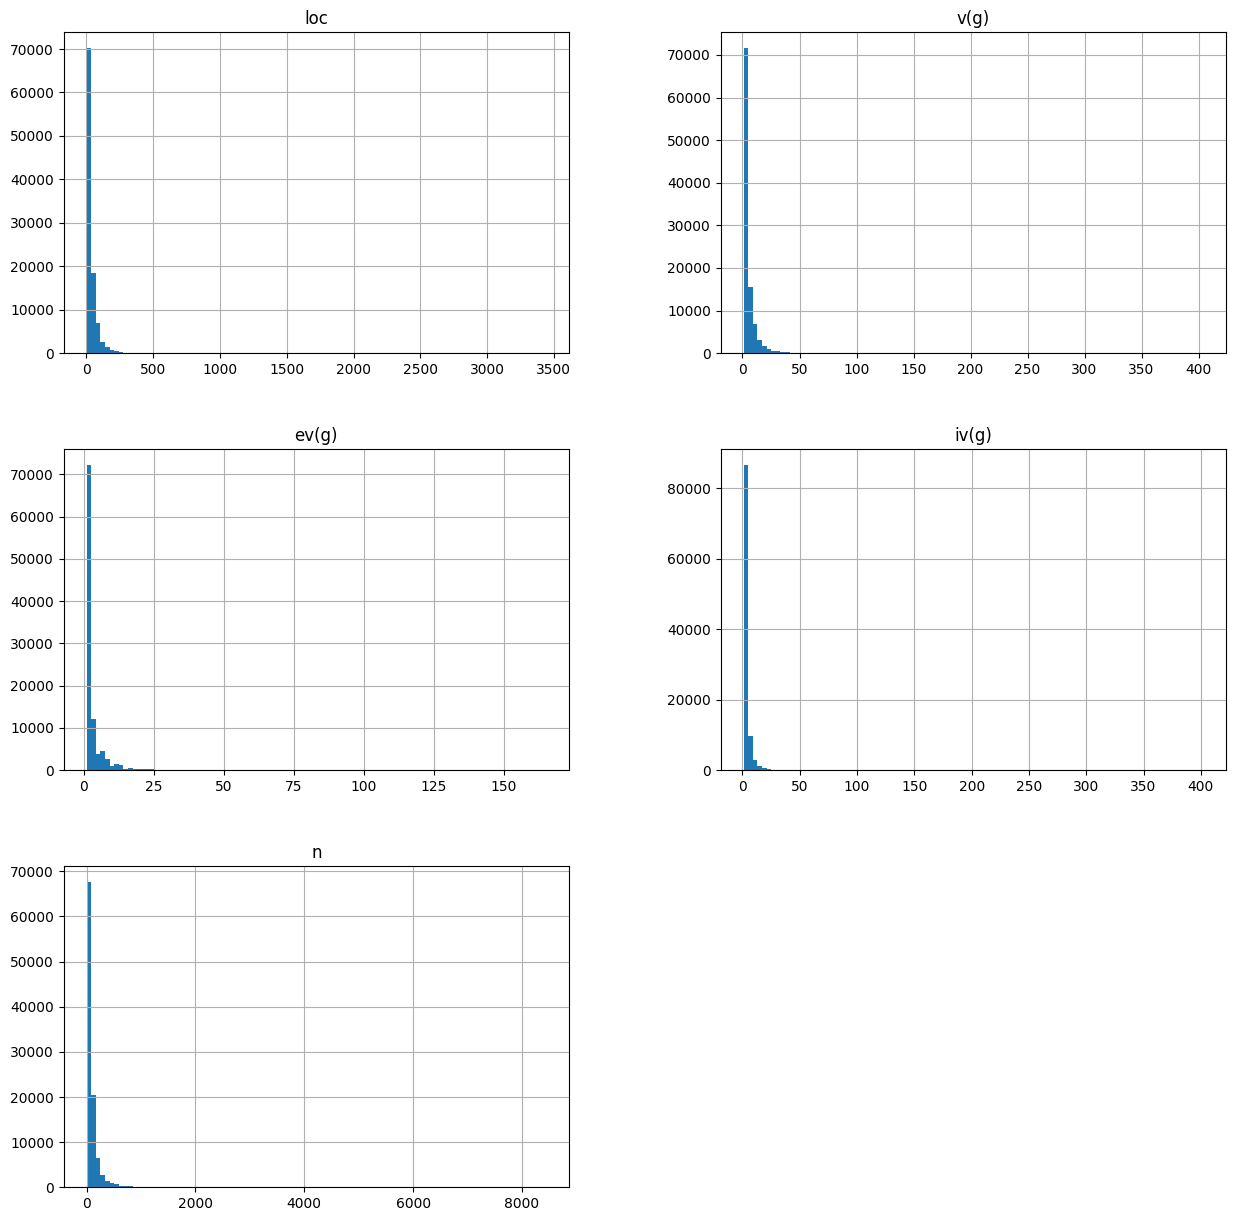

In [4]:
df.iloc[:, 0:5].hist(figsize=(15, 15), bins = 100)

array([[<Axes: title={'center': 'v'}>, <Axes: title={'center': 'l'}>],
       [<Axes: title={'center': 'd'}>, <Axes: title={'center': 'i'}>]],
      dtype=object)

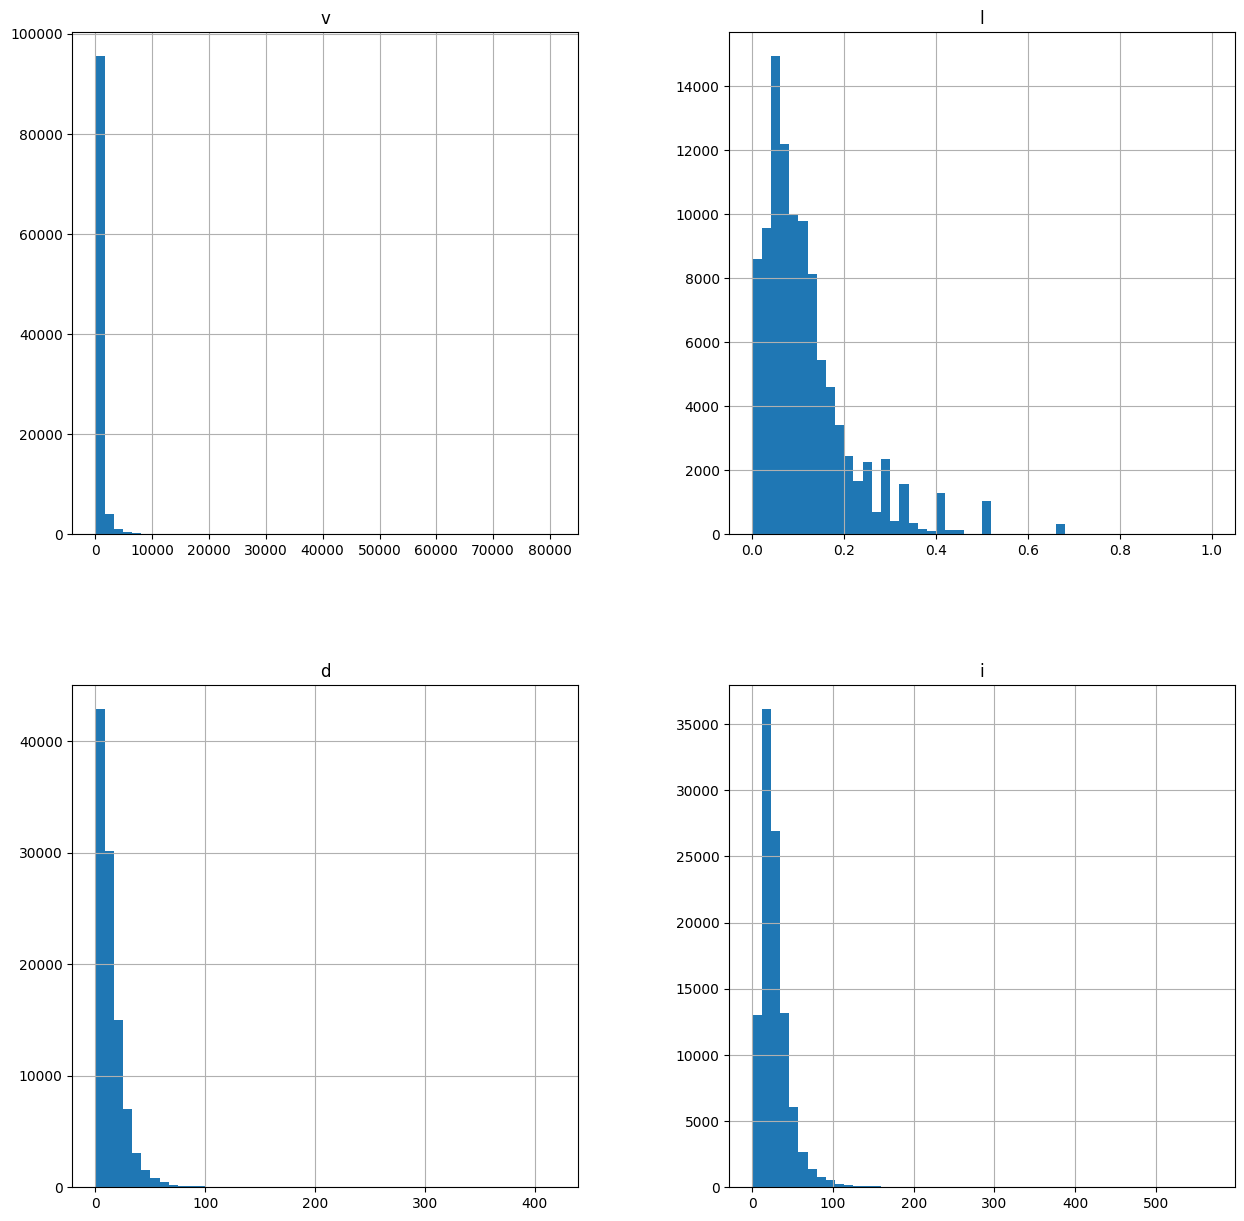

In [5]:
df.iloc[:, 5:9].hist(figsize=(15, 15), bins = 50)

array([[<Axes: title={'center': 'e'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 't'}>,
        <Axes: title={'center': 'lOCode'}>]], dtype=object)

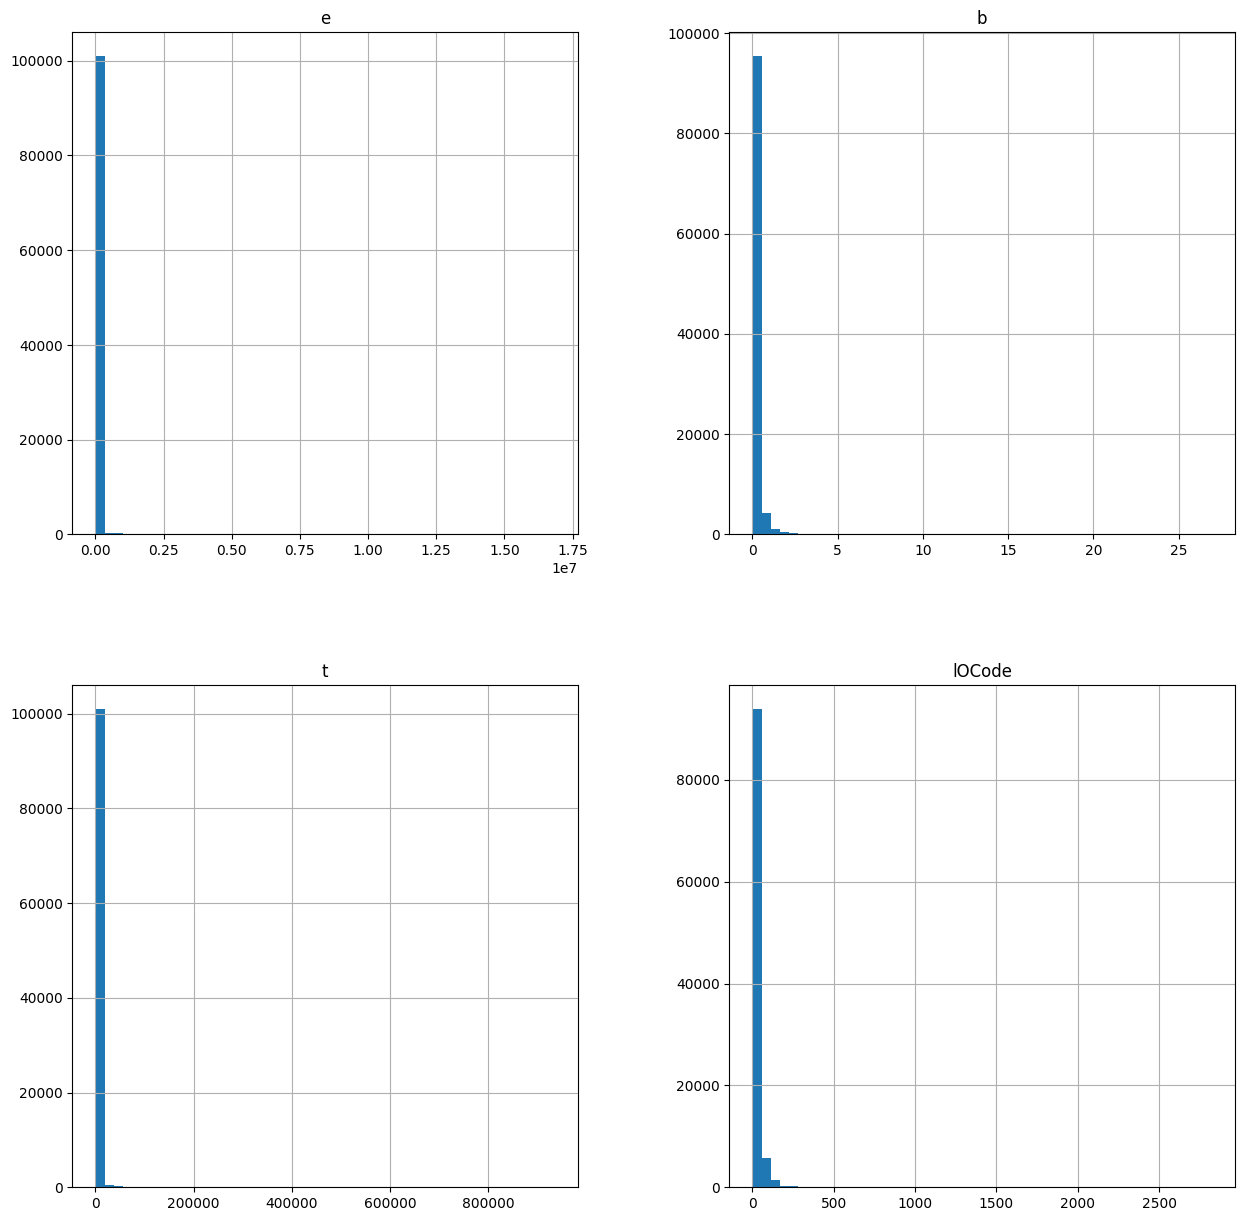

In [6]:
df.iloc[:, 9:13].hist(figsize=(15, 15), bins = 50)

array([[<Axes: title={'center': 'lOComment'}>,
        <Axes: title={'center': 'lOBlank'}>],
       [<Axes: title={'center': 'locCodeAndComment'}>,
        <Axes: title={'center': 'uniq_Op'}>]], dtype=object)

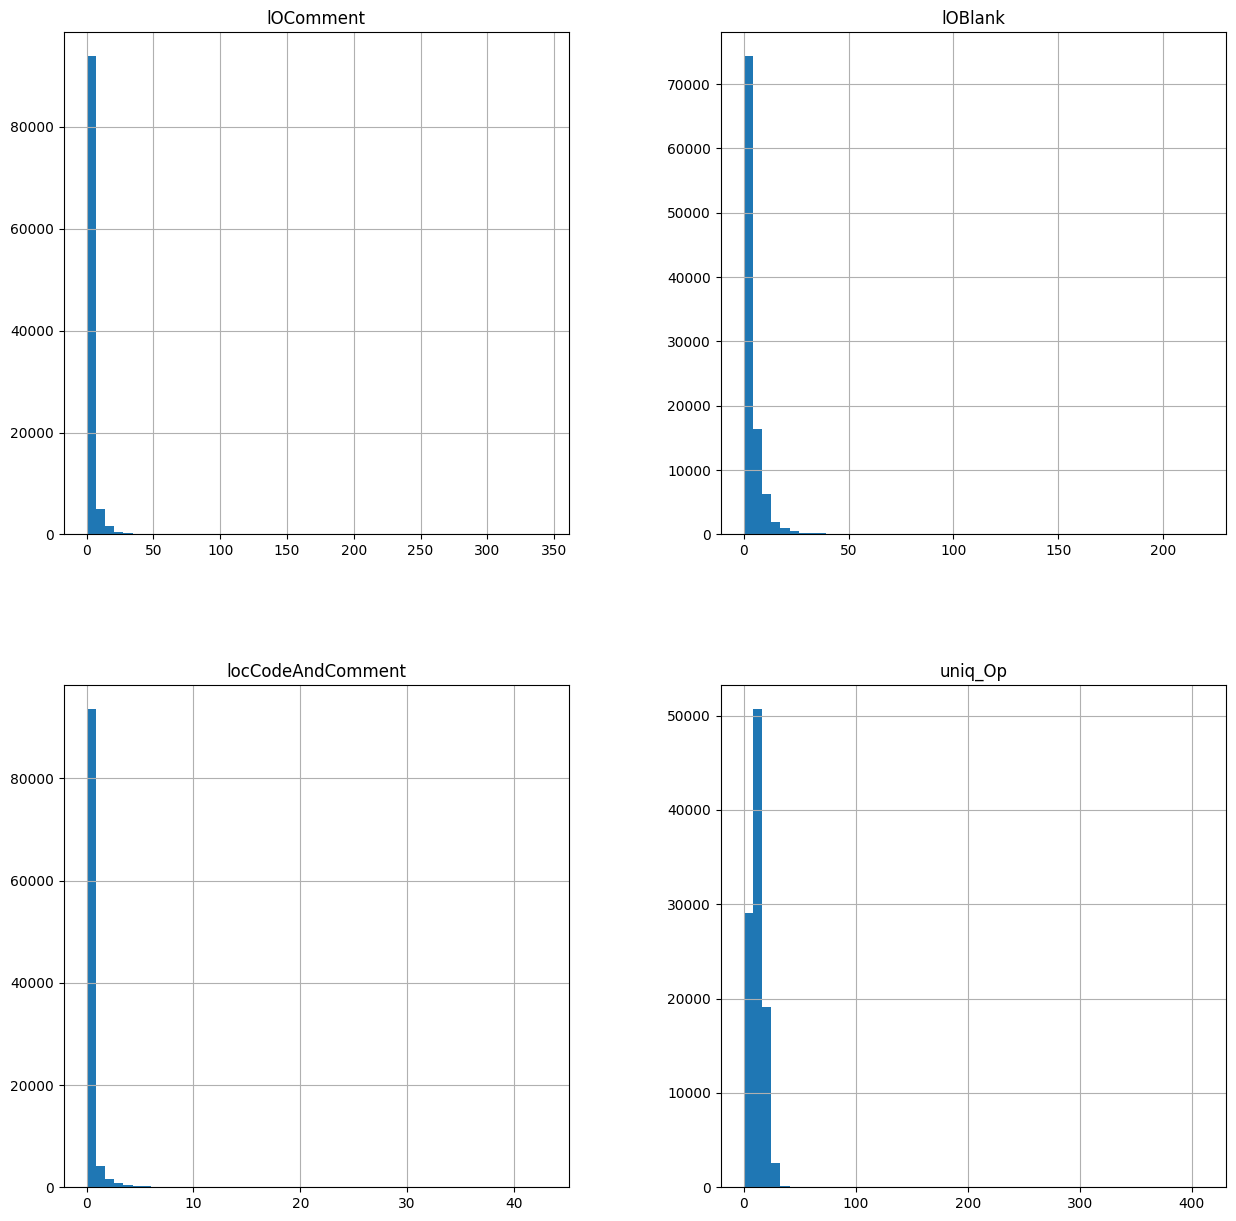

In [7]:
df.iloc[:, 13:17].hist(figsize=(15, 15), bins = 50)

array([[<Axes: title={'center': 'uniq_Opnd'}>,
        <Axes: title={'center': 'total_Op'}>],
       [<Axes: title={'center': 'total_Opnd'}>,
        <Axes: title={'center': 'branchCount'}>]], dtype=object)

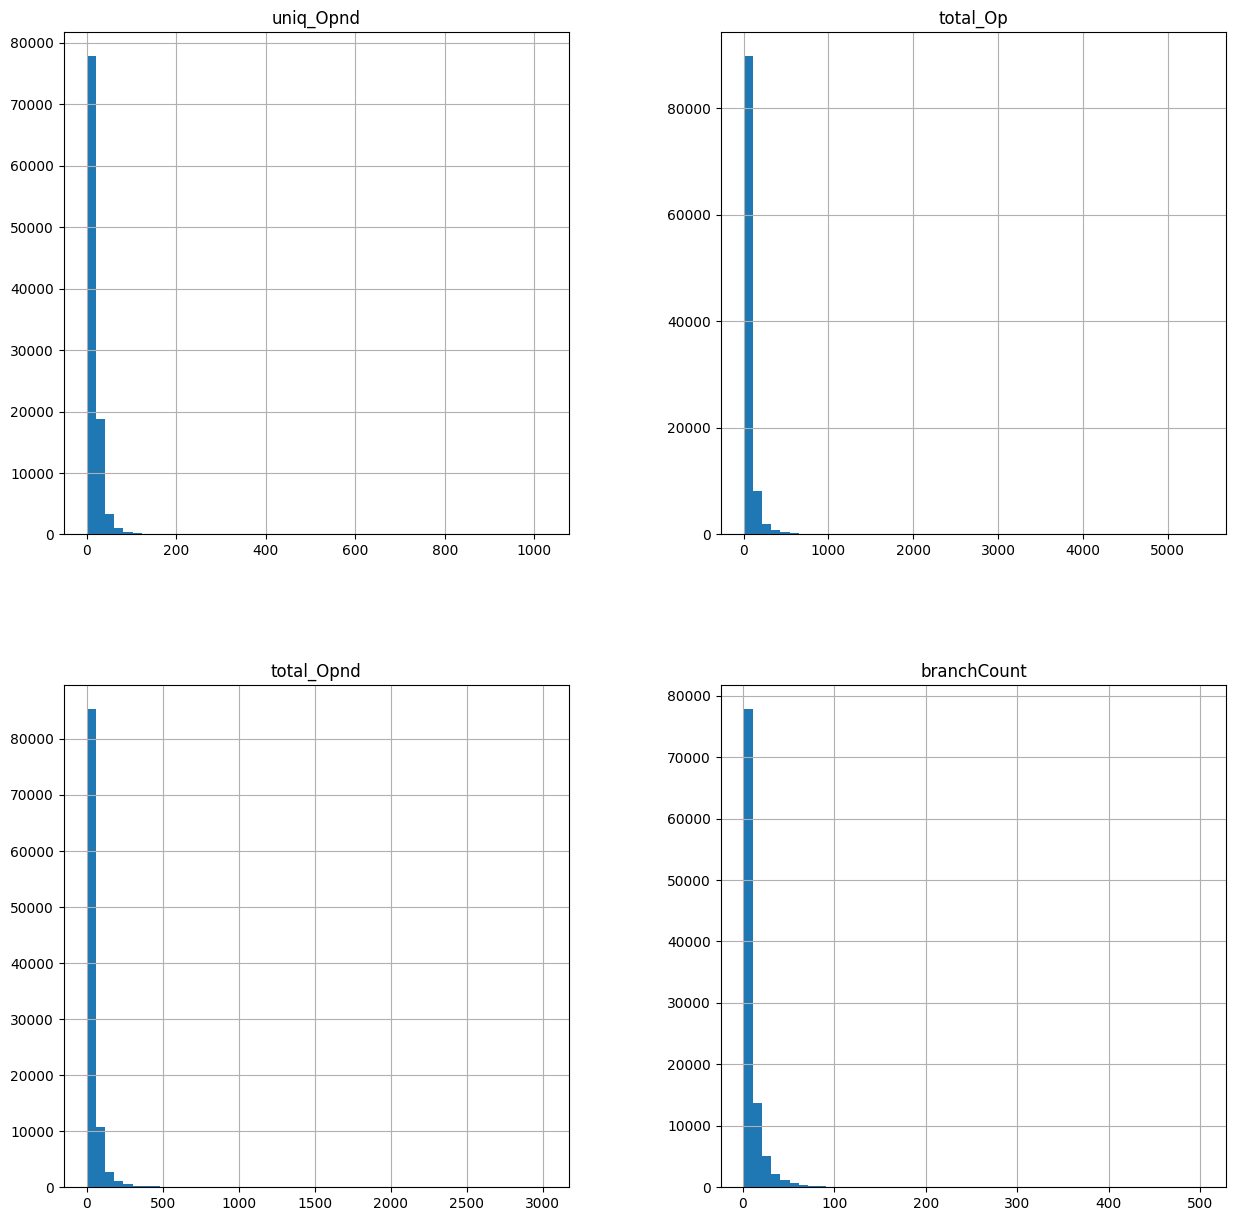

In [8]:
df.iloc[:, 17:23].hist(figsize=(15, 15), bins = 50)

interval columns not set, guessing: ['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']


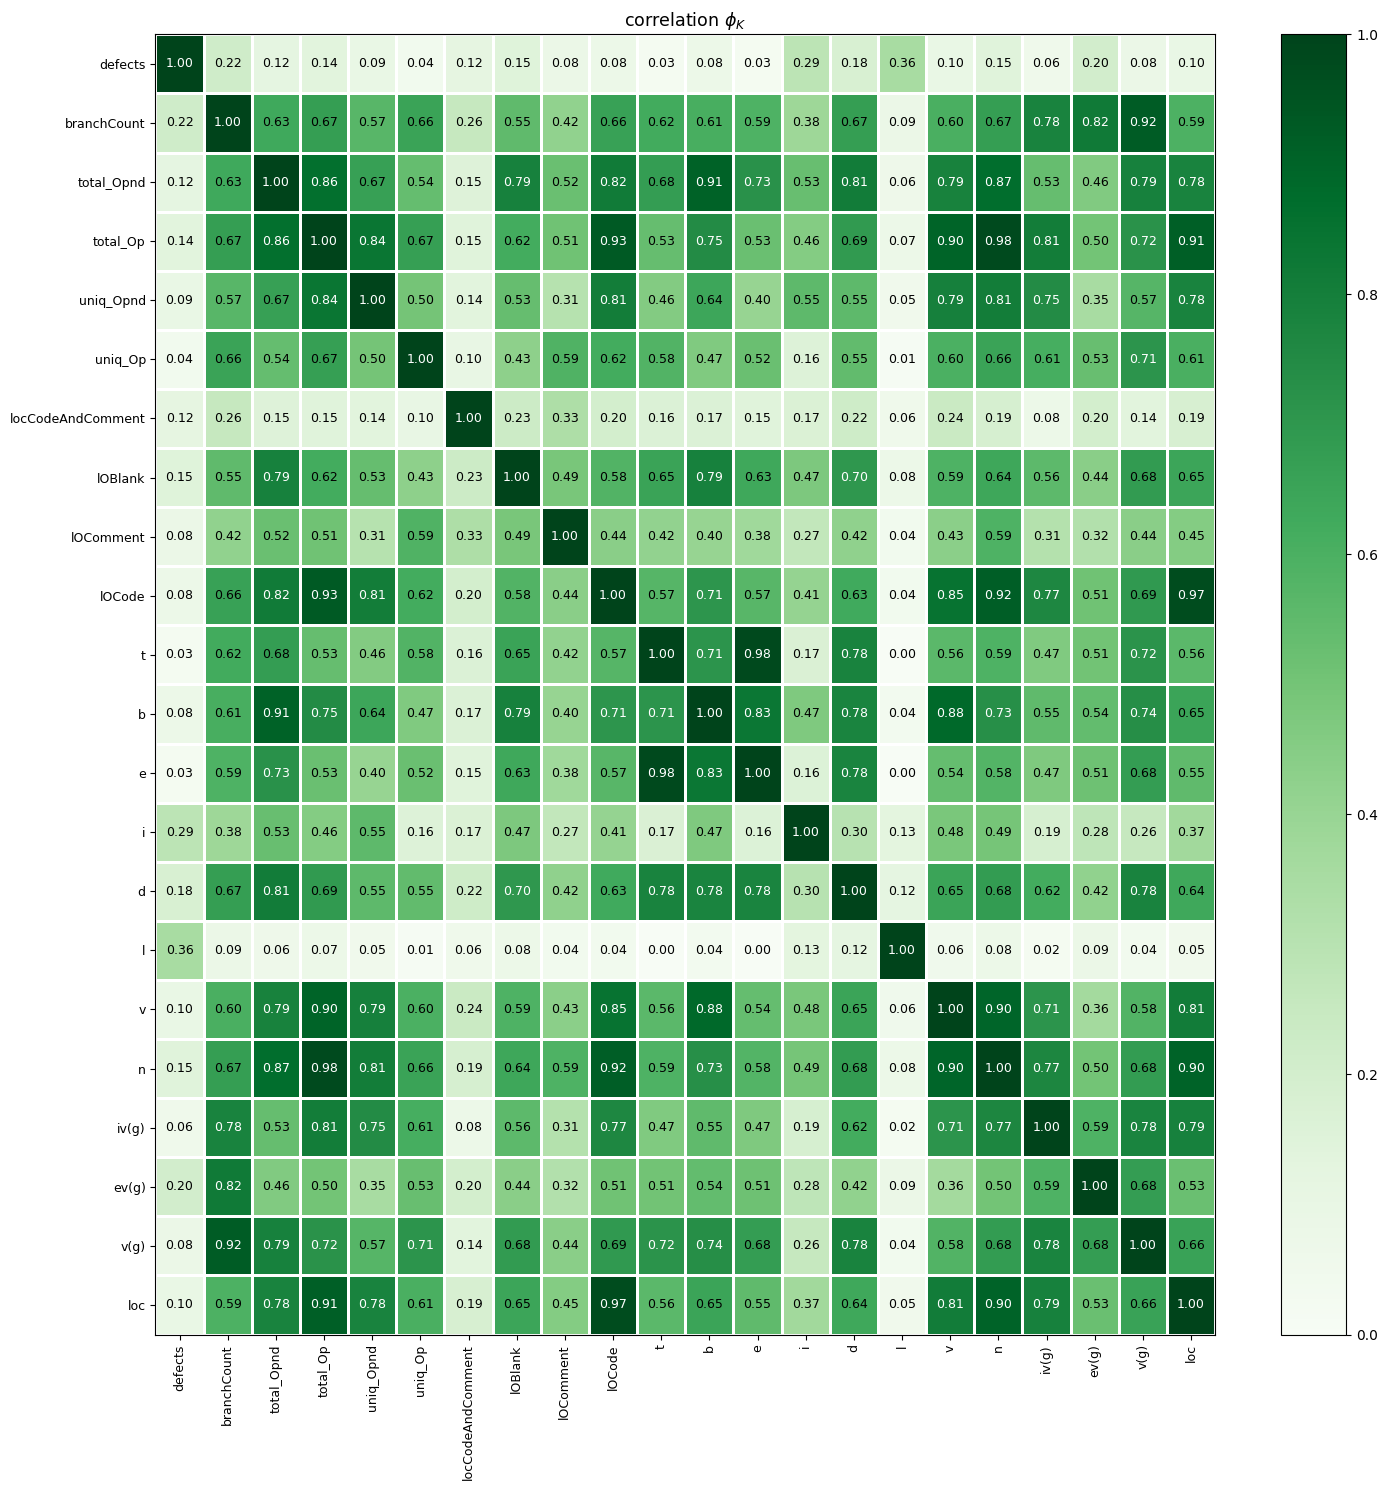

In [9]:
# Посмотрим на матрицу корреляции
phik_overview = df.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.9, figsize=(15, 15))
plt.tight_layout()

EDA показывает (например, сравнение максимума с 95% процентилем и гистограммы), что у нас есть огромные выбросы по абсолютно каждой переменной (кроме таргета). Посмотрим, как изменится датасет, если удалить все выбросы.

Удаление всех выбросов приводит к тому, что остаётся только 62,7% от исходных данных, что неприемлемо.

Удаление всех данных выше 95% процентиля приводит к тому, что остаётся 78,2% от исходных данных, что тоже неприемлемо.

Удаление всех данных выше 99% процентиля приводит к тому, что остаётся 95% от исходных данных. При этом удаляется 13% целевого класса. Это довольно много, хотя интересно обучить 2 модели -- одну на всём датасете, одну на очищенном и посравнивать их метрики на всём и на очищенном датасетах соответственно.

В итоге df_removed_outliers -- датасет, в которым удалены далее выше 99% перцентиля. На нём лучше видно распределение данных на гистограммах и также интересно посмотреть как будет выглядеть phik-корреляция.

In [10]:
df_length = df.shape[0]
df_length

101763

In [11]:
def remove_outliers(df):
    # Копируем DataFrame, чтобы не изменять оригинал
    df_cleaned = df.copy()
    
    # Создаем маску для всех выбросов
    mask = pd.Series([True] * len(df_cleaned))
    
    for column in df_cleaned.select_dtypes(include=['float64', 'int64']).columns:
        # Вычисляем Q1 (25-й перцентиль) и Q3 (75-й перцентиль)
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Определяем границы для выбросов
        lower_bound = Q1 - 1.5 * IQR
        # upper_bound = Q3 + 1.5 * IQR
        upper_bound = df_cleaned[column].quantile(0.99)

        # Обновляем маску для удаления выбросов
        # mask &= (df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)
        mask &= (df_cleaned[column] <= upper_bound)

    # Оставляем только строки без выбросов
    df_cleaned = df_cleaned[mask]
    
    # Находим удаленные выбросы
    df_outliers = df[~mask]
    
    return df_cleaned, df_outliers

In [12]:
df_no_outliers, df_removed_outliers = remove_outliers(df)

In [13]:
df_no_outliers.shape[0]/df.shape[0]

0.9492644674390496

In [14]:
# Посмотрим на разделение таргета
print('Исходный датасет:')
print(df.defects.value_counts(normalize=True))
print(df.defects.value_counts())
print('\n')
print('Очищенный датасет:')
print(df_no_outliers.defects.value_counts(normalize=True))
print(df_no_outliers.defects.value_counts())
print('\n')
print('Удалённый датасет:')
print(df_removed_outliers.defects.value_counts(normalize=True))
print(df_removed_outliers.defects.value_counts())
print('\n')

Исходный датасет:
defects
False   0.7734
True    0.2266
Name: proportion, dtype: float64
defects
False    78699
True     23064
Name: count, dtype: int64


Очищенный датасет:
defects
False   0.7944
True    0.2056
Name: proportion, dtype: float64
defects
False    76742
True     19858
Name: count, dtype: int64


Удалённый датасет:
defects
True    0.6210
False   0.3790
Name: proportion, dtype: float64
defects
True     3206
False    1957
Name: count, dtype: int64




In [15]:
df.shape

(101763, 22)

array([[<Axes: title={'center': 'total_Op'}>,
        <Axes: title={'center': 'total_Opnd'}>],
       [<Axes: title={'center': 'branchCount'}>,
        <Axes: title={'center': 'defects'}>]], dtype=object)

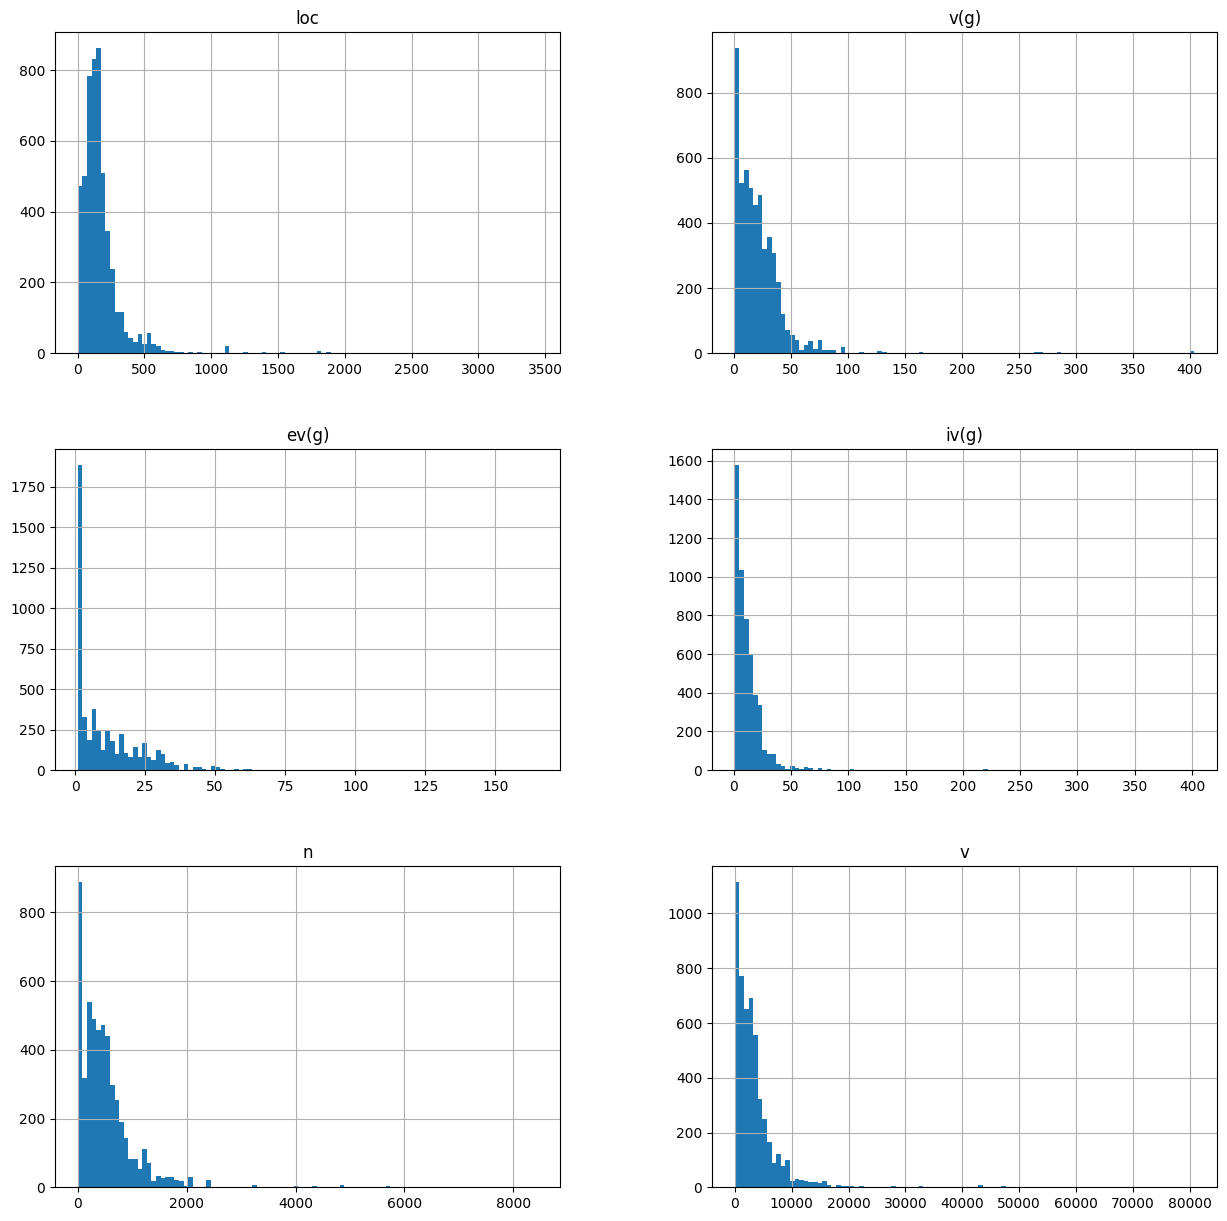

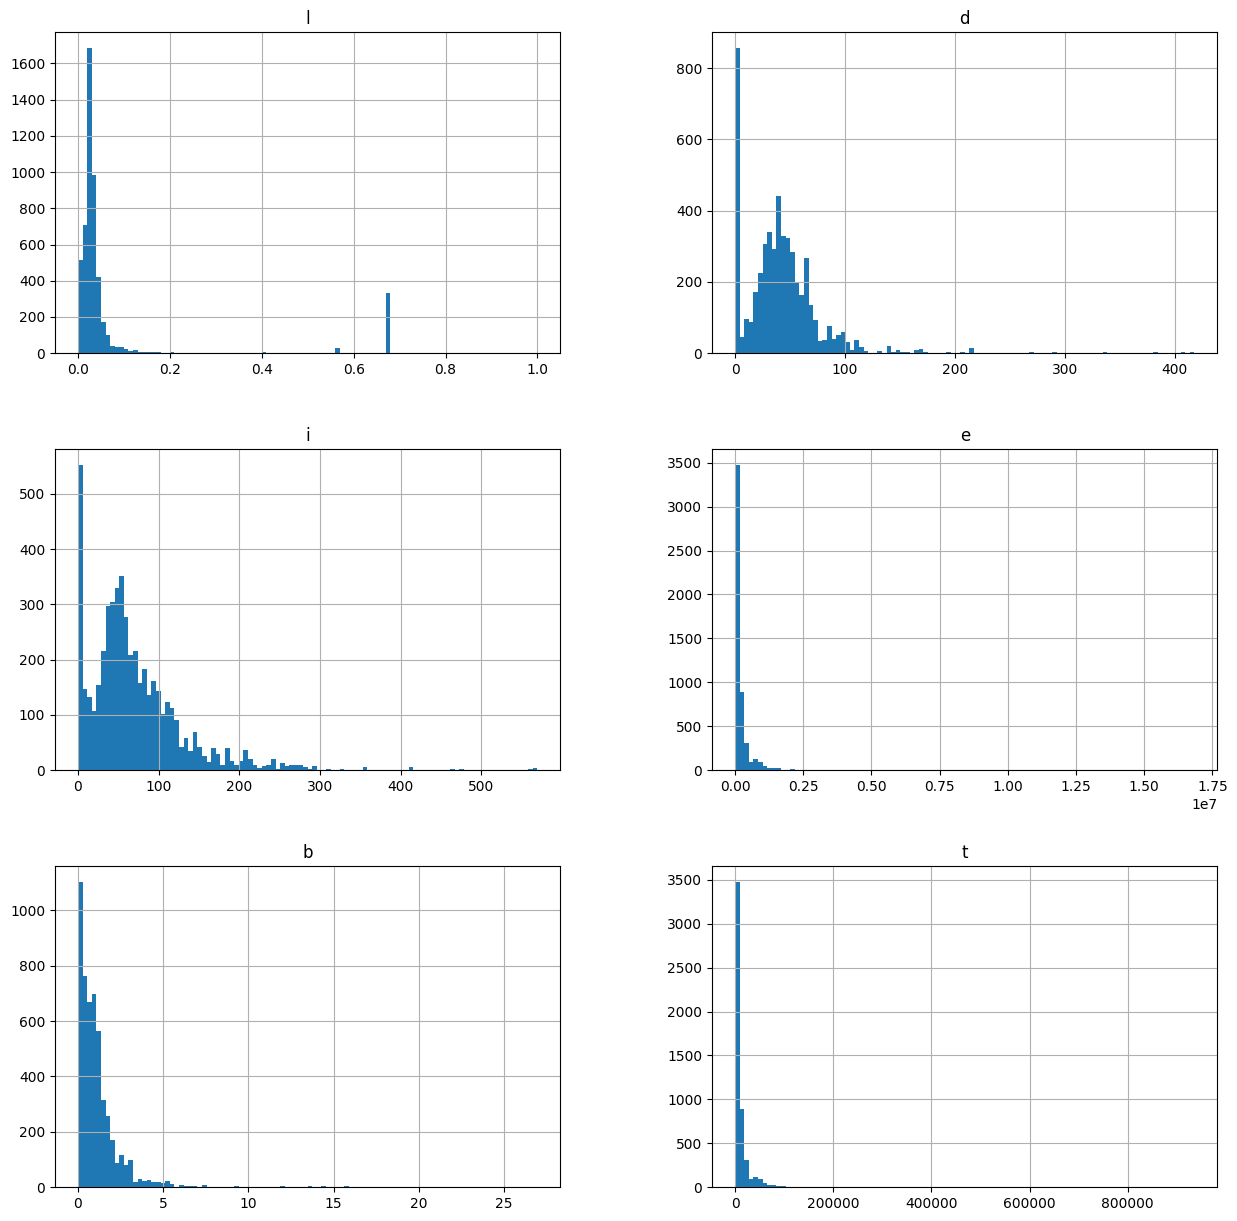

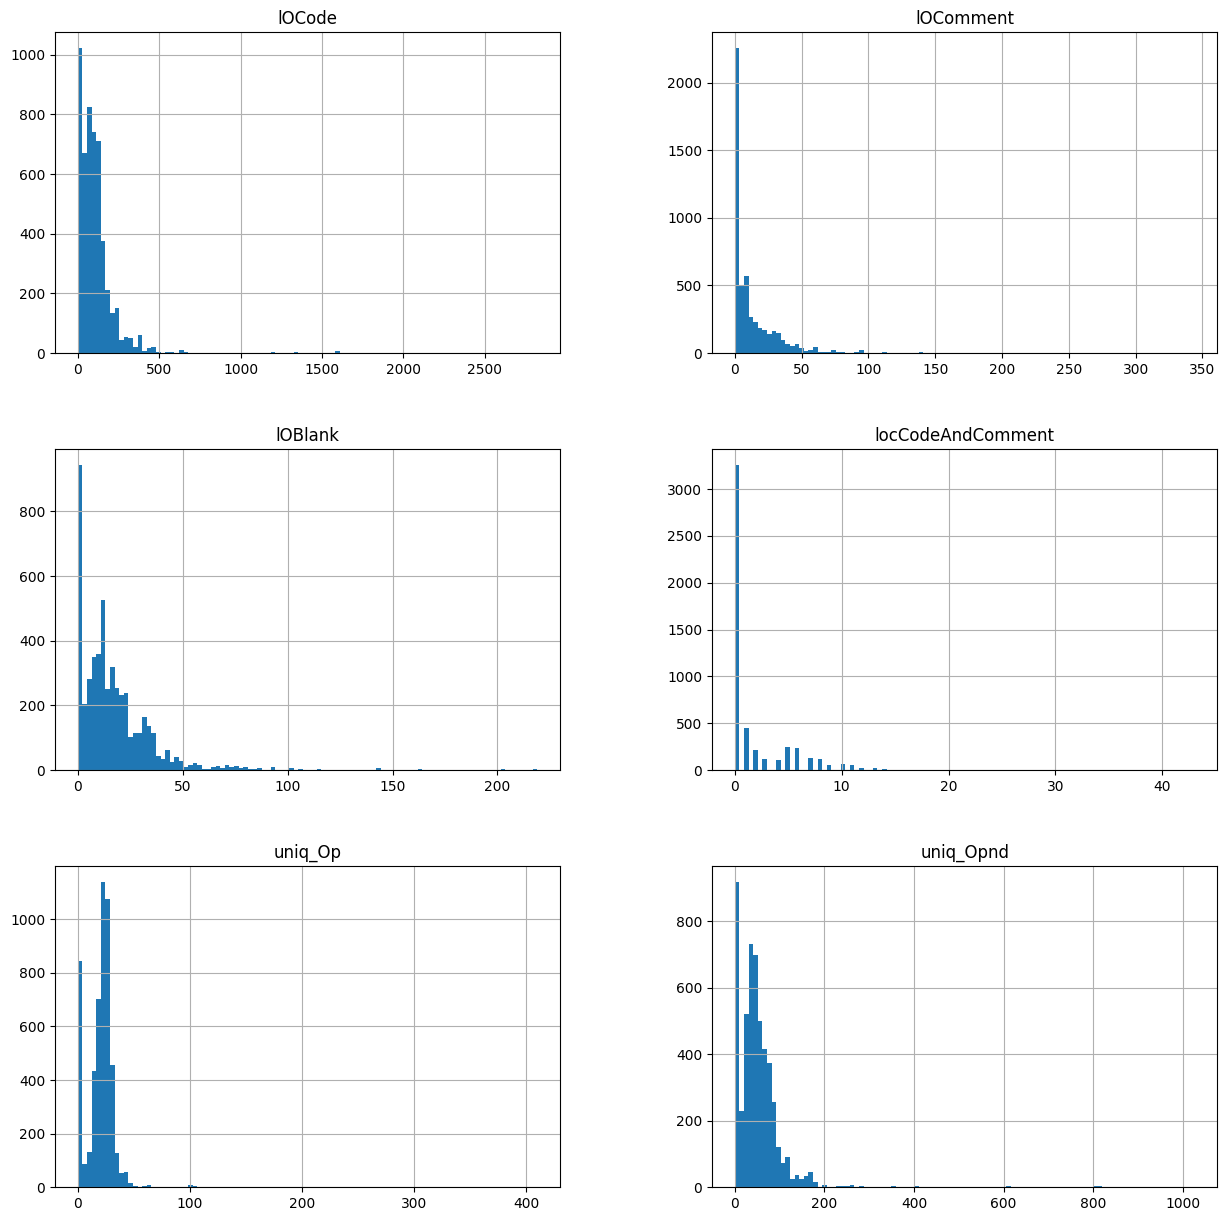

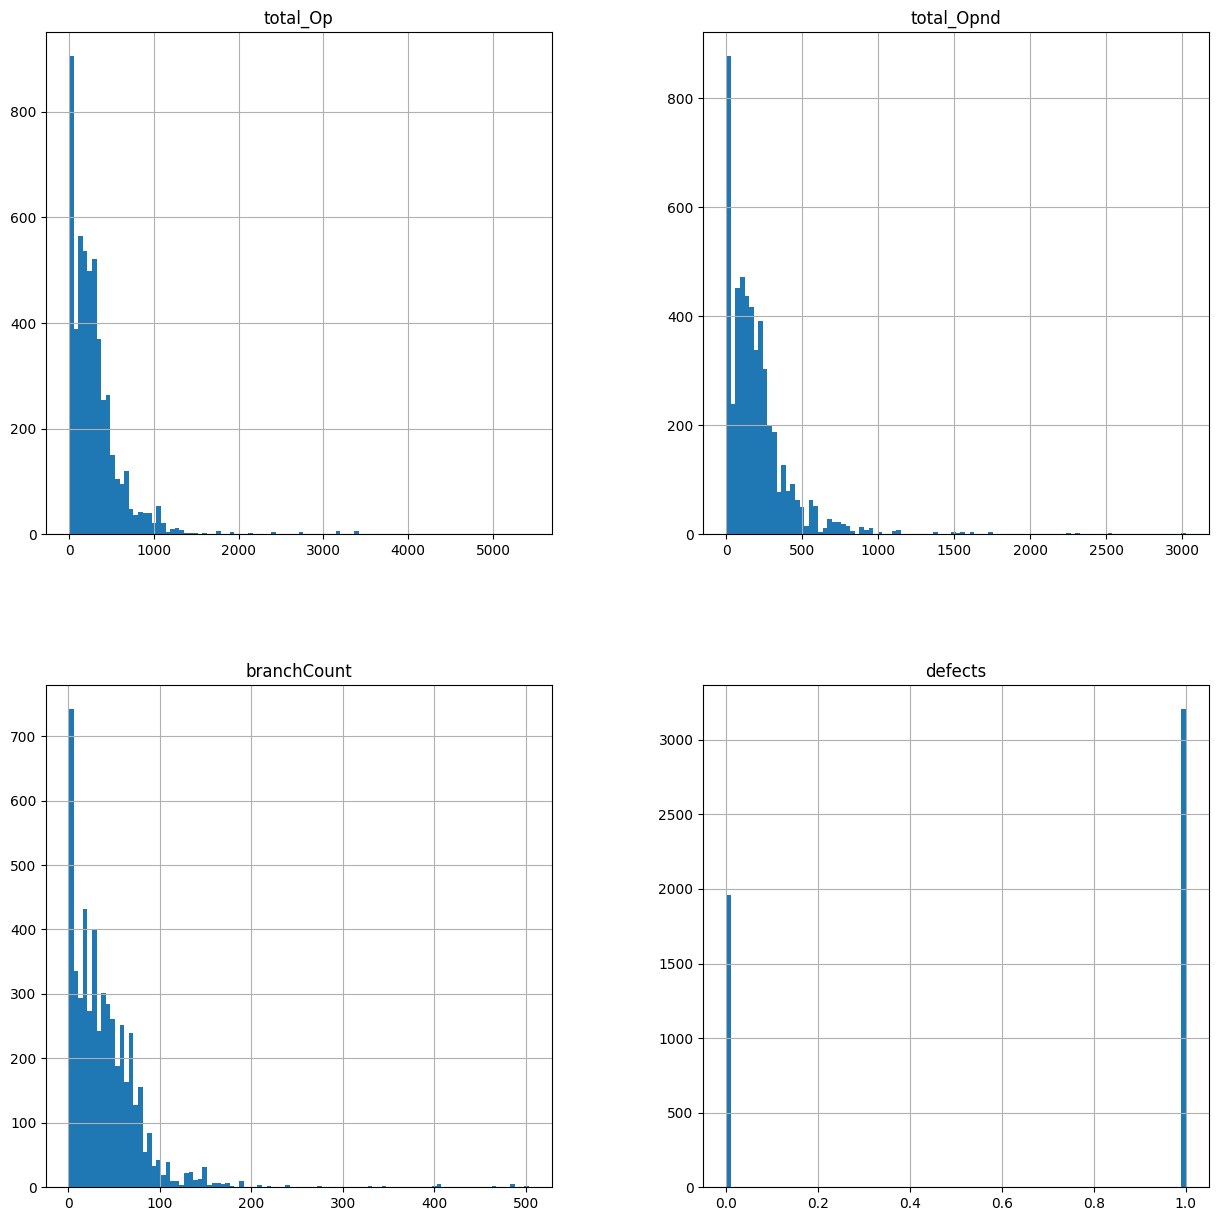

In [16]:
df *= 1
df_removed_outliers *= 1
df_removed_outliers.iloc[:, 0:6].hist(figsize=(15, 15), bins = 100)
df_removed_outliers.iloc[:, 6:12].hist(figsize=(15, 15), bins = 100)
df_removed_outliers.iloc[:, 12:18].hist(figsize=(15, 15), bins = 100)
df_removed_outliers.iloc[:, 18:].hist(figsize=(15, 15), bins = 100)


interval columns not set, guessing: ['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects']


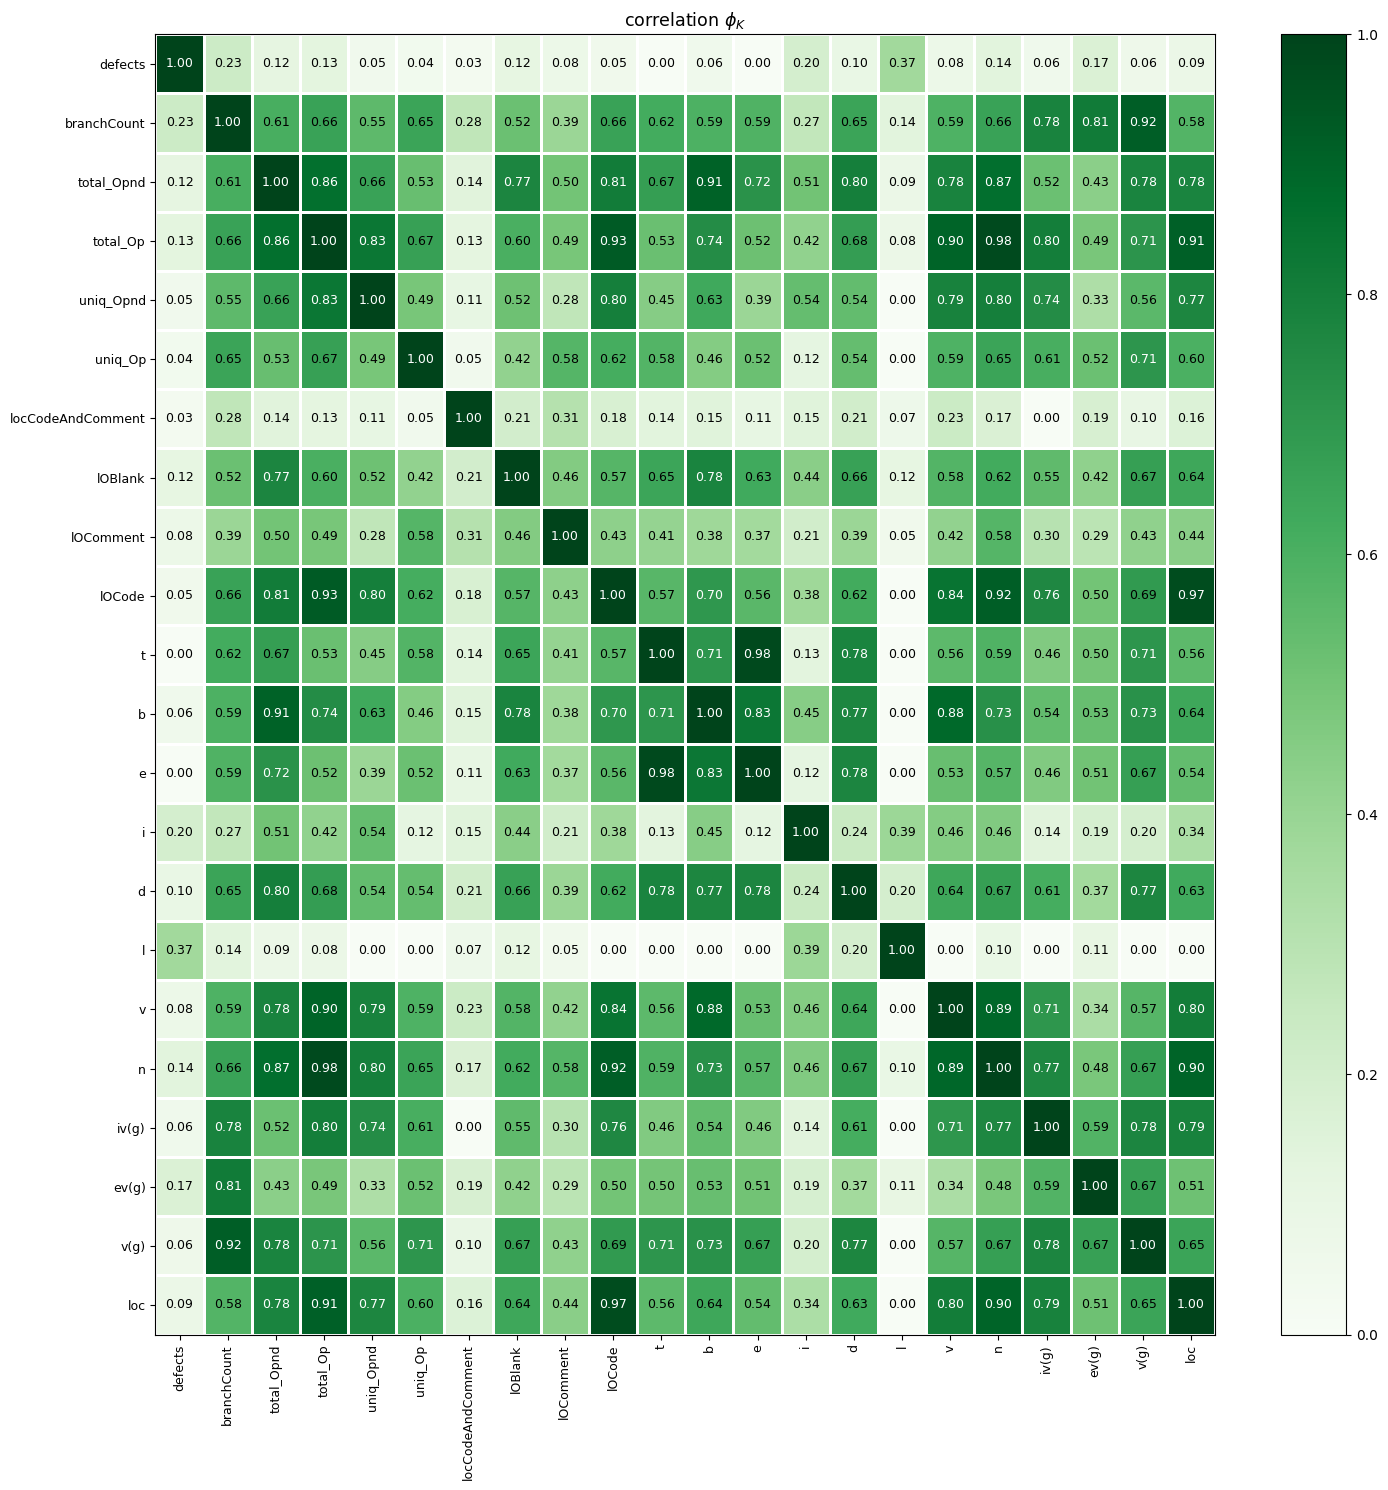

In [17]:
# Посмотрим на матрицу корреляции
phik_overview = df_removed_outliers.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.9, figsize=(15, 15))
plt.tight_layout()

У очищенного датасета снизилась корреляция таргета с 'i' с 0,29 до 0,2, у 'l' и 'branchCount' увеличилась на одну сотую.
Сначала будем обучать нейросеть на всех данных. Затем попробуем удалить часть высокоскоррелированных признаков и признаки, которые слабо скоррелированы с таргетом.

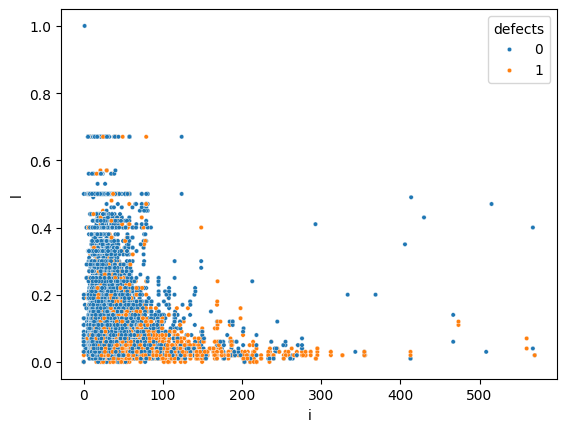

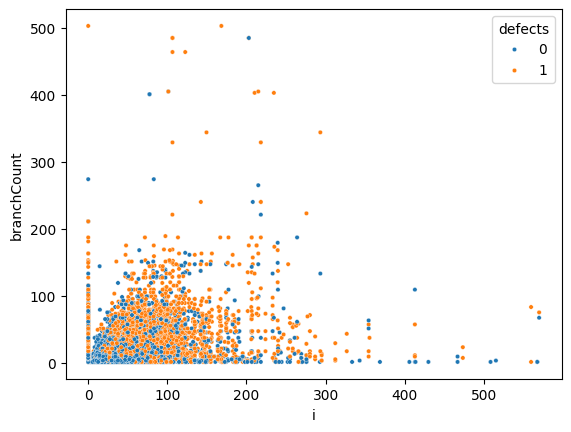

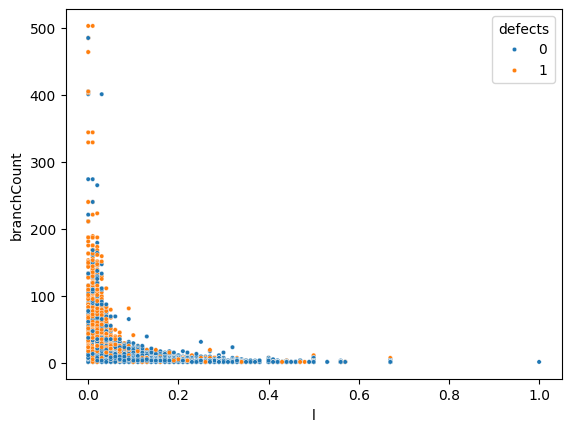

In [18]:
# Построим pairplots для наиболее скоррелированных с таргетом признаков

high_cor_feat = ['i', 'l', 'branchCount']
pairs = list(combinations(high_cor_feat, 2))

for pair in pairs:
        sns.scatterplot(
                data = df[[pair[0], pair[1], 'defects']]
                , x = pair[0]
                , y = pair[1]
                , s = 10
                , hue='defects')
        plt.show()

# df.columns

Видно, по графикам 'branchCount'-'l', 'l'-'i', что классы можно разделить линейно с некоторой точностью. Особых идей по генерации новых признаков это нам не даёт, остаётся лишь в дальнейшем удалить часть высокоскоррелированных признаков.

In [19]:
# Предобработка данных

# Разделение на фичи и таргет
features = df.drop('defects', axis = 1)
target = df['defects']

# Разделение на обучающую и тестовую части

features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=2, test_size=0.2, stratify=target)

# Стандартизация данных
scaler = StandardScaler()
features_train = pd.DataFrame(scaler.fit_transform(features_train), columns = features_train.columns)
features_test = pd.DataFrame(scaler.fit_transform(features_test), columns = features_test.columns)

# features_train_norm = scaler.fit_transform(features_train)
# features_test_norm = scaler.transform(features_test)


target_train, target_test = target_train.to_numpy(), target_test.to_numpy()


In [20]:
# Создаём архитектуру нейросети

def create_model(features_train):
    model = Sequential()
    model.add(Input(shape=(features_train.shape[1],)))
    model.add(Dense(16, activation='relu'))    # Далее соответственно число нейронов и функция активации
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'auc']
                  )
    return model

In [21]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(target_train), y=target_train)

In [22]:
model = create_model(features_train)

N = 100

history = model.fit(features_train, target_train,
           validation_data=(features_test, target_test),
           epochs=N,
           batch_size=128,
           class_weight = {0: class_weights[0], 1: class_weights[1]}
           )

Epoch 1/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6532 - auc: 0.7431 - loss: 0.6010 - precision: 0.3823 - val_accuracy: 0.7327 - val_auc: 0.7802 - val_loss: 0.5610 - val_precision: 0.4427
Epoch 2/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7429 - auc: 0.7865 - loss: 0.5578 - precision: 0.4565 - val_accuracy: 0.7340 - val_auc: 0.7821 - val_loss: 0.5629 - val_precision: 0.4440
Epoch 3/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7414 - auc: 0.7900 - loss: 0.5534 - precision: 0.4527 - val_accuracy: 0.7423 - val_auc: 0.7822 - val_loss: 0.5614 - val_precision: 0.4540
Epoch 4/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7488 - auc: 0.7900 - loss: 0.5515 - precision: 0.4607 - val_accuracy: 0.7398 - val_auc: 0.7832 - val_loss: 0.5485 - val_precision: 0.4510
Epoch 5/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7488 - auc: 0.7915 - loss: 0.5518 - precision: 0.4651 - val_accuracy: 0.7458 - val_auc: 0.7836 - val_loss: 0.5447

In [23]:
# auc_df = pd.DataFrame(zip([history.history['auc'], history.history['val_auc']]), columns=['auc', 'val_auc'])

def show_best_metric(history, metric):
    df_metric = pd.DataFrame(
    {
        metric: history.history[metric],
        f'val_{metric}': history.history[f'val_{metric}']
    }
    )
    display(df_metric[df_metric[f'val_{metric}'] == df_metric[f'val_{metric}'].max()])

show_best_metric(history, 'auc')
show_best_metric(history, 'accuracy')
show_best_metric(history, 'precision')

,auc,val_auc
61,0.7959,0.7850


,accuracy,val_accuracy
40,0.7521,0.7641


,precision,val_precision
40,0.4679,0.4844


In [24]:
def check_metrics(history, figure_name):

    train = history.history[f'{figure_name}']
    val = history.history[f'val_{figure_name}']

    # Построение графика лосса и валидационного лосса
    epochs = range(1, len(train) + 1)
    plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')
    plt.plot(epochs, val, 'b', label=f'Validation {figure_name}')
    plt.title(f'Training and Validation {figure_name}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{figure_name}')
    plt.legend()
    plt.show()

/tmp/ipykernel_17275/2180351603.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


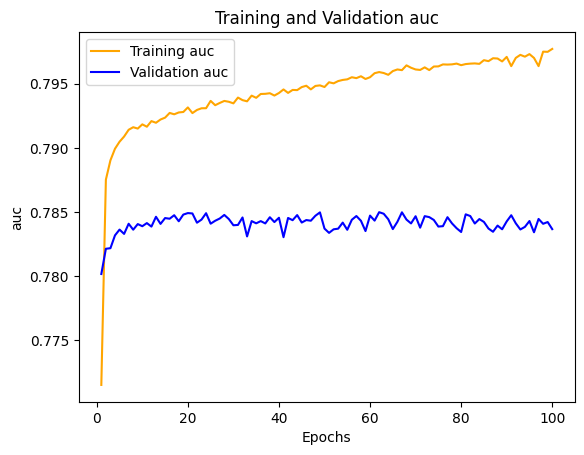

In [25]:
check_metrics(history, 'auc')

In [26]:
print(df.columns)

low_corr = ['lOCode', 'lOComment', 'uniq_Op', 'uniq_Opnd', 't', 'b', 'e', 'iv(g)', 'v(g)']
df.drop(low_corr, axis = 1, inplace = True)

features_train.drop(low_corr, axis = 1, inplace = True)
features_test.drop(low_corr, axis = 1, inplace = True)

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects'],
      dtype='object')


interval columns not set, guessing: ['loc', 'ev(g)', 'n', 'v', 'l', 'd', 'i', 'lOBlank', 'locCodeAndComment', 'total_Op', 'total_Opnd', 'branchCount', 'defects']


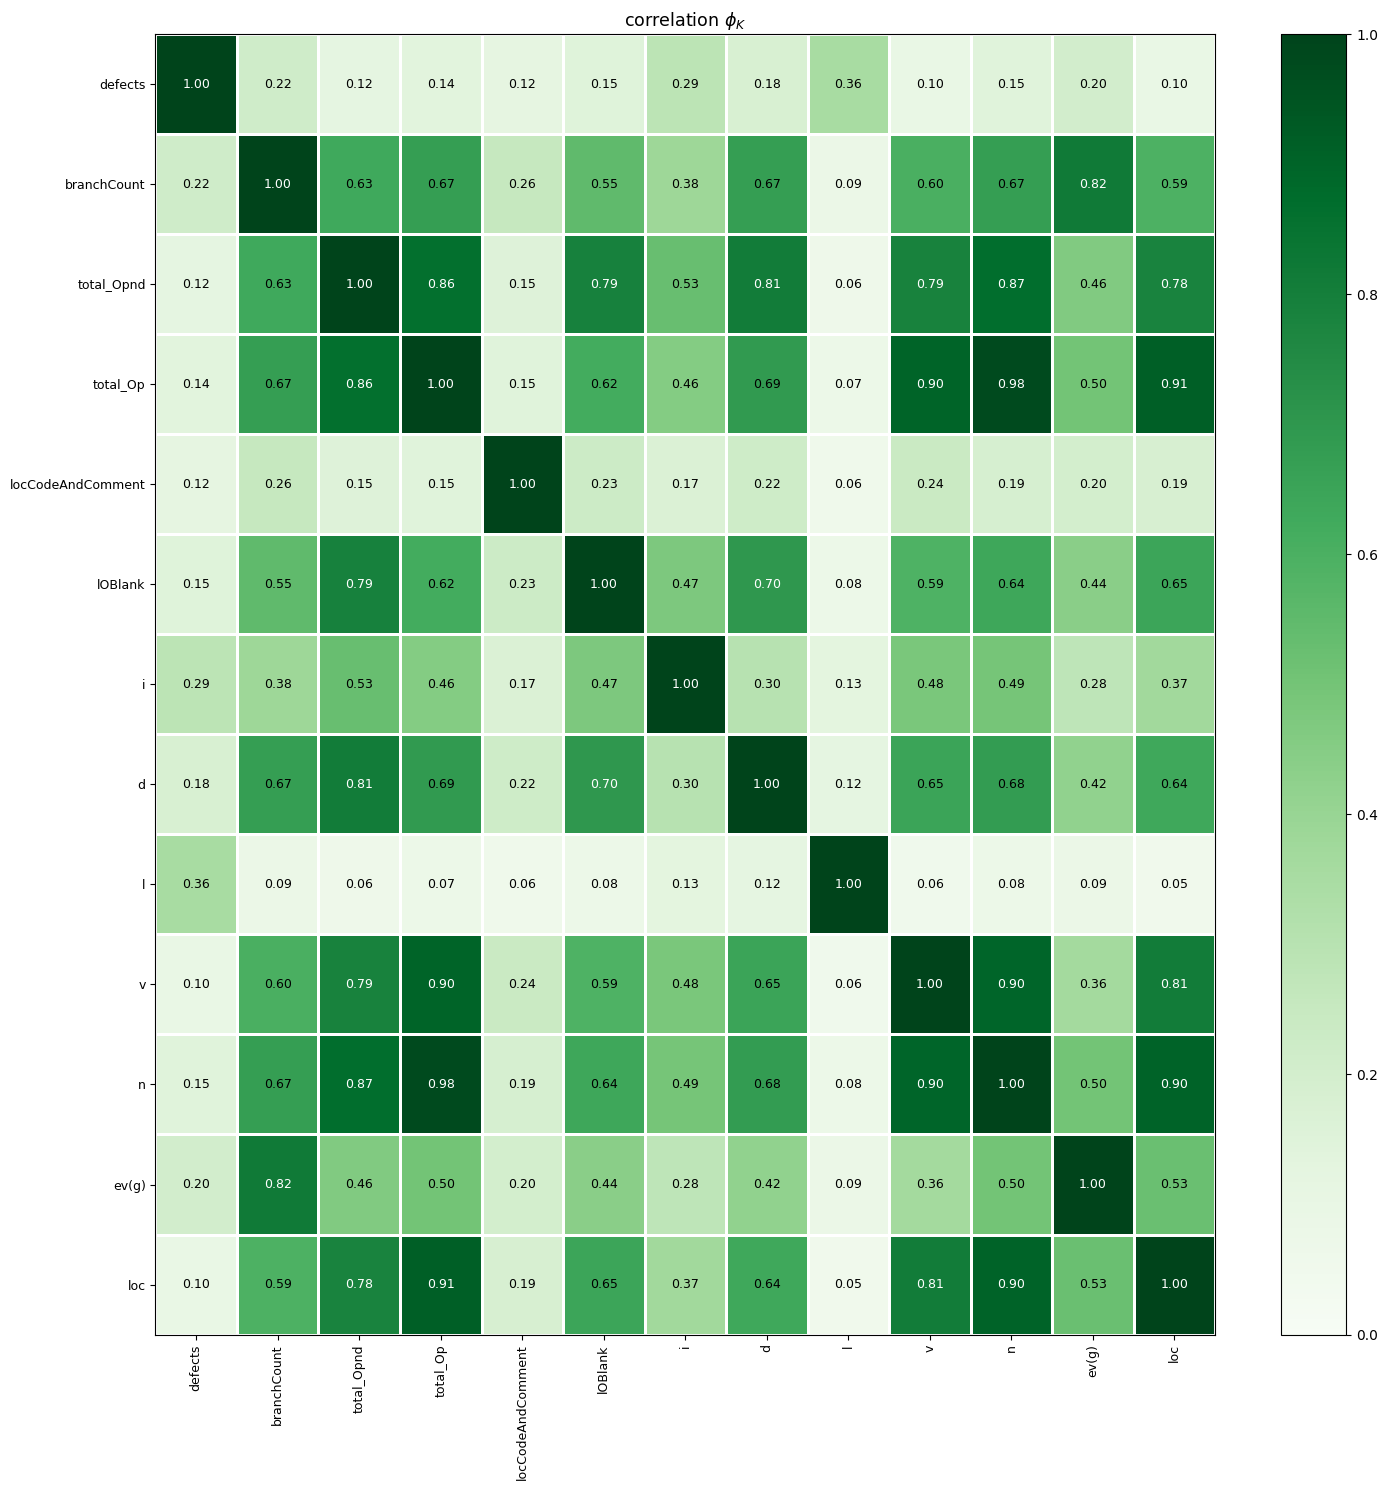

In [27]:
phik_overview = df.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.9, figsize=(15, 15))
plt.tight_layout()

У нас так же остаются пары сильно скоррелированных признаков

total_Op - loc, n, v, total_Opnd
branchCount - ev(g)
total_Opnd - loc, n, v, d, IOBlank, total_Op
loc - n, v, total_Op
n, v

Удалим часть из них ev(g), v, total_Op, total_Opnd, loc

In [28]:
pairwise_corr = ['ev(g)', 'v', 'total_Op', 'total_Opnd', 'loc']
df.drop(pairwise_corr, axis = 1, inplace = True)


interval columns not set, guessing: ['n', 'l', 'd', 'i', 'lOBlank', 'locCodeAndComment', 'branchCount', 'defects']


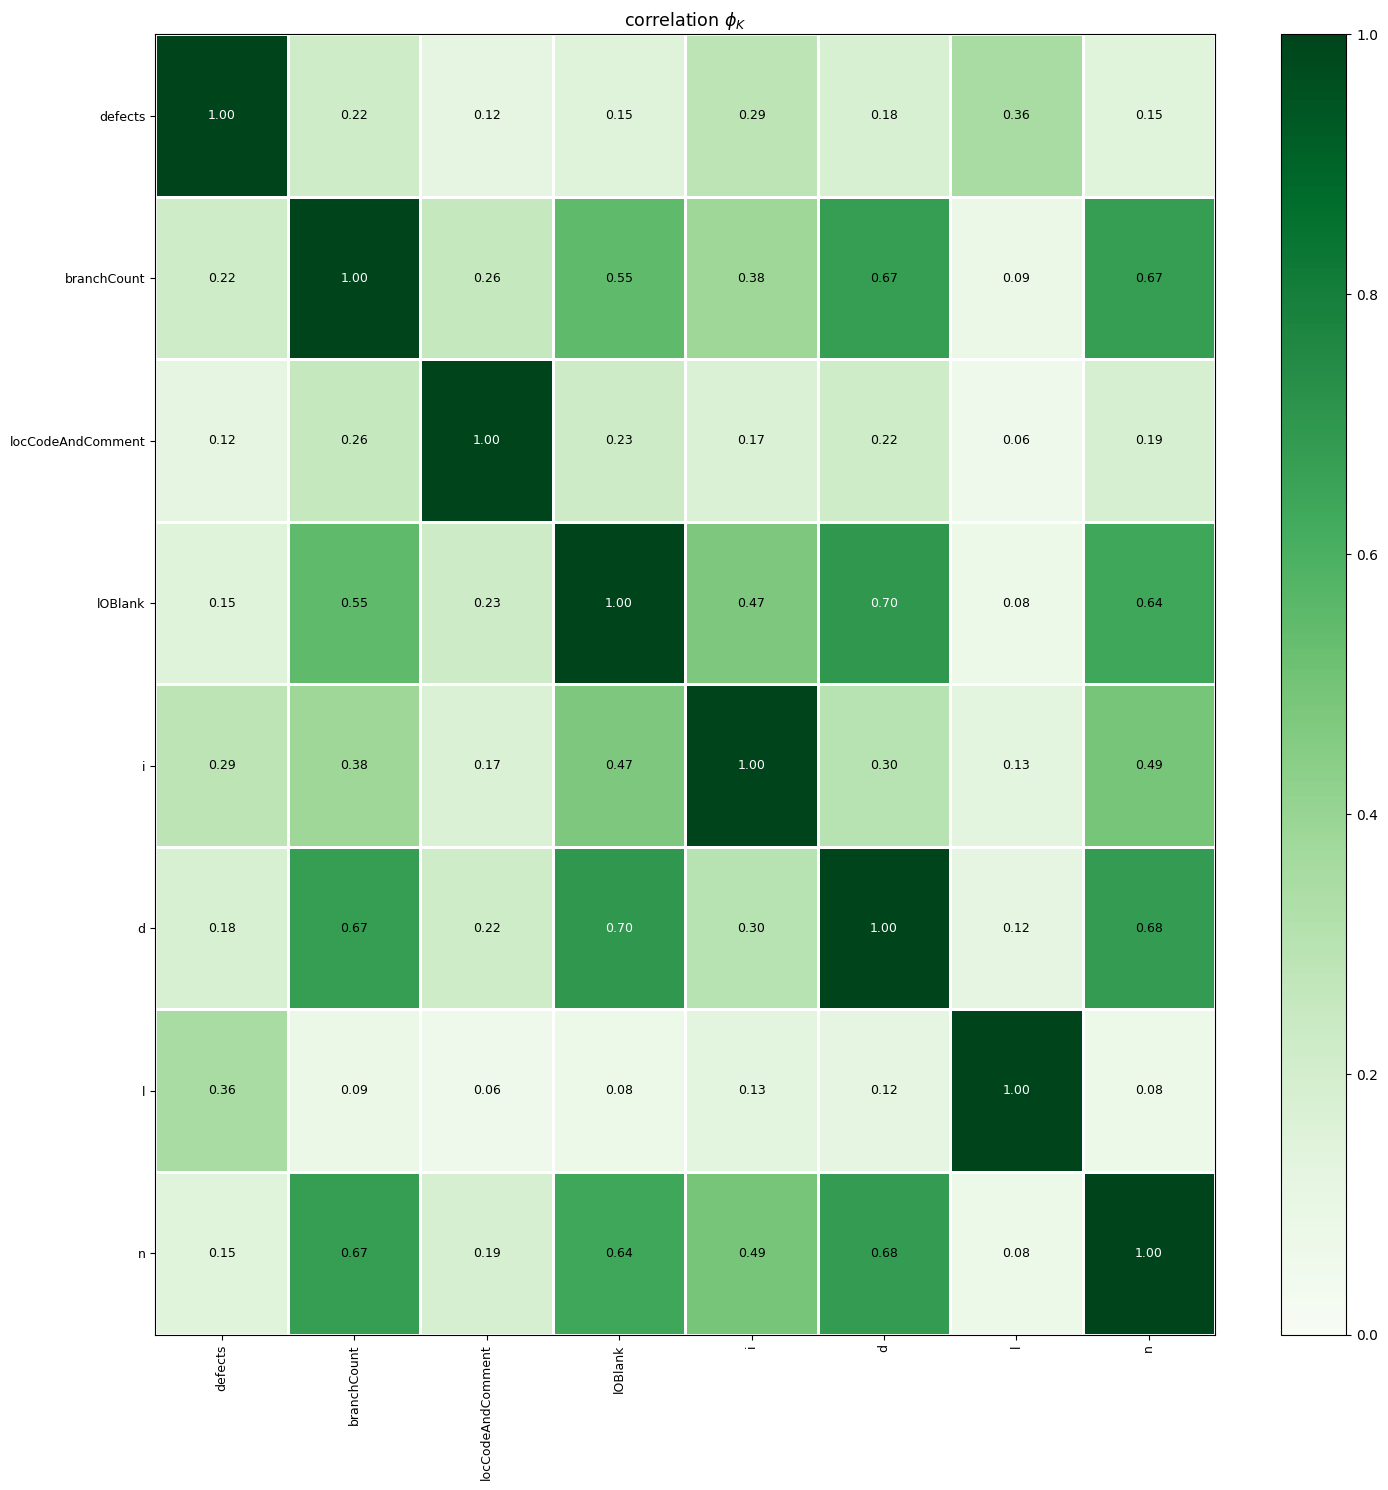

In [29]:
phik_overview = df.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.9, figsize=(15, 15))
plt.tight_layout()

In [30]:
features_train_reduced = features_train.drop(pairwise_corr, axis = 1)
features_test_reduced = features_test.drop(pairwise_corr, axis = 1)

In [31]:
features_train_reduced.head()

,n,l,d,i,lOBlank,locCodeAndComment,branchCount
0,-0.5682,-1.1177,-0.9736,-1.2070,-0.6244,-0.1969,1.4804
1,-0.0550,-0.2177,-0.1993,0.4774,-0.1537,-0.1969,-0.1969
2,-0.5682,-1.1177,-0.9736,-1.2070,-0.6244,-0.1969,1.0611
3,-0.3853,1.1824,-0.6741,0.0674,-0.1537,-0.1969,-0.6162
4,-0.4325,2.2824,-0.7633,0.4538,-0.6244,-0.1969,-0.6162


In [32]:
model = create_model(features_train_reduced)

N = 100

history = model.fit(features_train_reduced, target_train,
           validation_data=(features_test_reduced, target_test),
           epochs=N,
           batch_size=128,
           class_weight = {0: class_weights[0], 1: class_weights[1]}
           )

Epoch 1/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6952 - auc: 0.7587 - loss: 0.5912 - precision: 0.4024 - val_accuracy: 0.7262 - val_auc: 0.7755 - val_loss: 0.5633 - val_precision: 0.4337
Epoch 2/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7332 - auc: 0.7812 - loss: 0.5642 - precision: 0.4432 - val_accuracy: 0.7203 - val_auc: 0.7775 - val_loss: 0.5728 - val_precision: 0.4281
Epoch 3/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7296 - auc: 0.7822 - loss: 0.5646 - precision: 0.4420 - val_accuracy: 0.7265 - val_auc: 0.7775 - val_loss: 0.5756 - val_precision: 0.4345
Epoch 4/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7344 - auc: 0.7830 - loss: 0.5611 - precision: 0.4434 - val_accuracy: 0.7308 - val_auc: 0.7782 - val_loss: 0.5688 - val_precision: 0.4396
Epoch 5/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7351 - auc: 0.7824 - loss: 0.5619 - precision: 0.4451 - val_accuracy: 0.7172 - val_auc: 0.7778 - val_loss: 0.5916

In [33]:
# Переобучение чуть меньше, метрика чуть хуже
show_best_metric(history, 'auc')
show_best_metric(history, 'accuracy')
show_best_metric(history, 'precision')

,auc,val_auc
73,0.7853,0.7800


,accuracy,val_accuracy
58,0.7379,0.7463


,precision,val_precision
58,0.4489,0.4577


/tmp/ipykernel_17275/2180351603.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


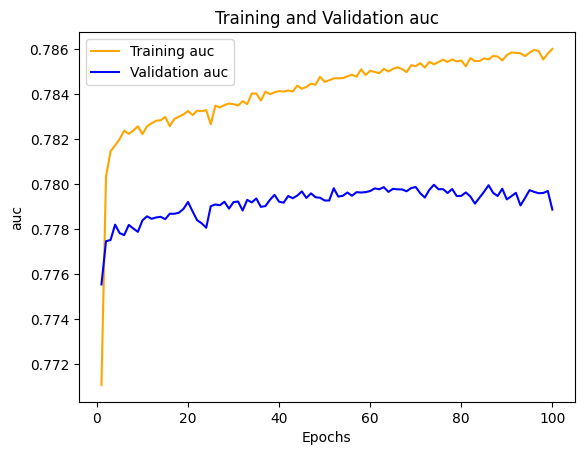

In [34]:
check_metrics(history, 'auc')

In [35]:
# Попробуем добавить новых фич

features_train_sq = features_train_reduced.copy()
features_test_sq = features_test_reduced.copy()

for column in features_train_reduced.columns:
    features_train_sq[f'{column}**2'] = features_train_reduced[column] ** 2
    features_test_sq[f'{column}**2'] = features_test_reduced[column] ** 2

    # features_train_sq[f'{column}**3'] = features_train_reduced[column] ** 3
    # features_test_sq[f'{column}**3'] = features_test_reduced[column] ** 3

In [36]:
model = create_model(features_train_sq)

N = 100

history = model.fit(features_train_sq, target_train,
           validation_data=(features_test_sq, target_test),
           epochs=N,
           batch_size=128,
           class_weight = {0: class_weights[0], 1: class_weights[1]}
           )

Epoch 1/100


637/637 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6843 - auc: 0.7192 - loss: 0.6514 - precision: 0.3862 - val_accuracy: 0.7224 - val_auc: 0.7715 - val_loss: 0.5736 - val_precision: 0.4292
Epoch 2/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7243 - auc: 0.7763 - loss: 0.5774 - precision: 0.4322 - val_accuracy: 0.7171 - val_auc: 0.7753 - val_loss: 0.5999 - val_precision: 0.4250
Epoch 3/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7272 - auc: 0.7769 - loss: 0.5745 - precision: 0.4387 - val_accuracy: 0.7285 - val_auc: 0.7764 - val_loss: 0.5777 - val_precision: 0.4366
Epoch 4/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7315 - auc: 0.7817 - loss: 0.5666 - precision: 0.4397 - val_accuracy: 0.7211 - val_auc: 0.7773 - val_loss: 0.5825 - val_precision: 0.4290
Epoch 5/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7323 - auc: 0.7805 - loss: 0.5656 - precision: 0.4420 - val_accuracy: 0.7298 - val_auc: 0.7753 - val_loss: 0.5504 - val_preci

,auc,val_auc
44,0.7842,0.7796


,accuracy,val_accuracy
13,0.7351,0.7432


,precision,val_precision
13,0.4454,0.4541


/tmp/ipykernel_17275/2180351603.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


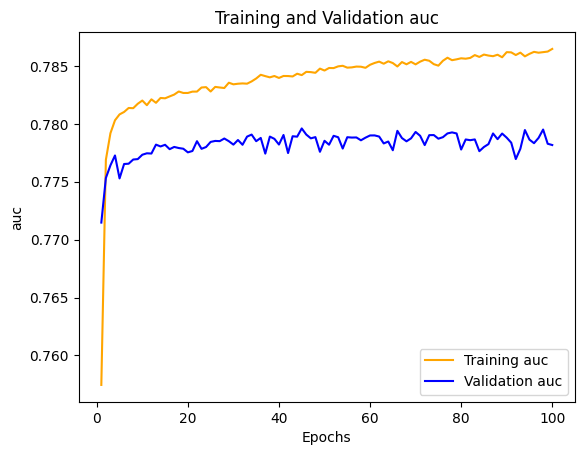

In [37]:
# улучшений нет
show_best_metric(history, 'auc')
show_best_metric(history, 'accuracy')
show_best_metric(history, 'precision')

check_metrics(history, 'auc')

In [38]:
def create_model_re(features_train):
    model = Sequential()
    model.add(Input(shape=(features_train.shape[1],)))
    model.add(Dense(16, activation='relu'))    # Далее соответственно число нейронов и функция активации
    model.add(Dropout(0.15))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.15))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.15))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'auc']
                  )
    return model

In [39]:
model = create_model_re(features_train_reduced)

N = 100

history = model.fit(features_train_reduced, target_train,
           validation_data=(features_test_reduced, target_test),
           epochs=N,
           batch_size=128,
           class_weight = {0: class_weights[0], 1: class_weights[1]}
           )

Epoch 1/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6318 - auc: 0.6523 - loss: 0.7146 - precision: 0.3342 - val_accuracy: 0.7233 - val_auc: 0.7693 - val_loss: 0.5622 - val_precision: 0.4301
Epoch 2/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7157 - auc: 0.7489 - loss: 0.5973 - precision: 0.4190 - val_accuracy: 0.7272 - val_auc: 0.7724 - val_loss: 0.5713 - val_precision: 0.4355
Epoch 3/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7255 - auc: 0.7647 - loss: 0.5809 - precision: 0.4311 - val_accuracy: 0.7083 - val_auc: 0.7740 - val_loss: 0.5874 - val_precision: 0.4166
Epoch 4/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7251 - auc: 0.7654 - loss: 0.5804 - precision: 0.4332 - val_accuracy: 0.7184 - val_auc: 0.7751 - val_loss: 0.5698 - val_precision: 0.4260
Epoch 5/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7262 - auc: 0.7642 - loss: 0.5815 - precision: 0.4361 - val_accuracy: 0.7076 - val_auc: 0.7760 - val_loss: 0.5819

637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7360 - auc: 0.7776 - loss: 0.5681 - precision: 0.4481 - val_accuracy: 0.7405 - val_auc: 0.7778 - val_loss: 0.5760 - val_precision: 0.4502
Epoch 18/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7384 - auc: 0.7727 - loss: 0.5703 - precision: 0.4459 - val_accuracy: 0.7244 - val_auc: 0.7778 - val_loss: 0.5870 - val_precision: 0.4324
Epoch 19/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7364 - auc: 0.7751 - loss: 0.5703 - precision: 0.4484 - val_accuracy: 0.7296 - val_auc: 0.7775 - val_loss: 0.5796 - val_precision: 0.4377
Epoch 20/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7324 - auc: 0.7766 - loss: 0.5691 - precision: 0.4427 - val_accuracy: 0.7292 - val_auc: 0.7778 - val_loss: 0.5768 - val_precision: 0.4376
Epoch 21/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7296 - auc: 0.7728 - loss: 0.5718 - precision: 0.4382 - val_accuracy: 0.7392 - val_auc: 0.7776 - val_loss: 0.5773 - val_p

,auc,val_auc
91,0.7777,0.7794


,accuracy,val_accuracy
13,0.7343,0.7448


,precision,val_precision
13,0.4440,0.4557


/tmp/ipykernel_17275/2180351603.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


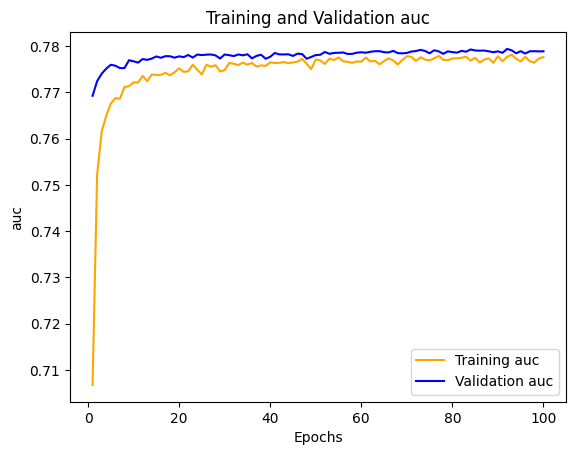

In [40]:
show_best_metric(history, 'auc')
show_best_metric(history, 'accuracy')
show_best_metric(history, 'precision')

check_metrics(history, 'auc')

In [41]:
def create_model_reg(features_train):
    model = Sequential()
    model.add(Input(shape=(features_train.shape[1],)))
    model.add(Dense(128, activation='relu'))    # Далее соответственно число нейронов и функция активации
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'auc']
                  )
    return model

In [42]:
model = create_model_reg(features_train_reduced)

N = 100

early_stopping = EarlyStopping(monitor='val_auc', patience=5)
save_best_weights = ModelCheckpoint(filepath='./Best_auc_1.weights.h5',
                                    save_weights_only=True,
                                    monitor='val_auc',
                                    mode='max',
                                    save_best_only=True)

history = model.fit(features_train_reduced, target_train,
           validation_data=(features_test_reduced, target_test),
           epochs=N,
           batch_size=128,
           class_weight = {0: class_weights[0], 1: class_weights[1]},
           callbacks=[early_stopping, save_best_weights]
           )

Epoch 1/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6794 - auc: 0.7281 - loss: 0.6486 - precision: 0.3853 - val_accuracy: 0.7151 - val_auc: 0.7757 - val_loss: 0.5749 - val_precision: 0.4227
Epoch 2/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7200 - auc: 0.7729 - loss: 0.5754 - precision: 0.4285 - val_accuracy: 0.7258 - val_auc: 0.7777 - val_loss: 0.5689 - val_precision: 0.4341
Epoch 3/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7241 - auc: 0.7713 - loss: 0.5741 - precision: 0.4324 - val_accuracy: 0.7213 - val_auc: 0.7759 - val_loss: 0.5730 - val_precision: 0.4292
Epoch 4/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7318 - auc: 0.7750 - loss: 0.5657 - precision: 0.4334 - val_accuracy: 0.7300 - val_auc: 0.7786 - val_loss: 0.5653 - val_precision: 0.4385
Epoch 5/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7317 - auc: 0.7779 - loss: 0.5660 - precision: 0.4391 - val_accuracy: 0.7294 - val_auc: 0.7783 - val_loss: 0.5756

,auc,val_auc
9,0.7779,0.7787


,accuracy,val_accuracy
8,0.7320,0.7347


,precision,val_precision
8,0.4415,0.4436


/tmp/ipykernel_17275/2180351603.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


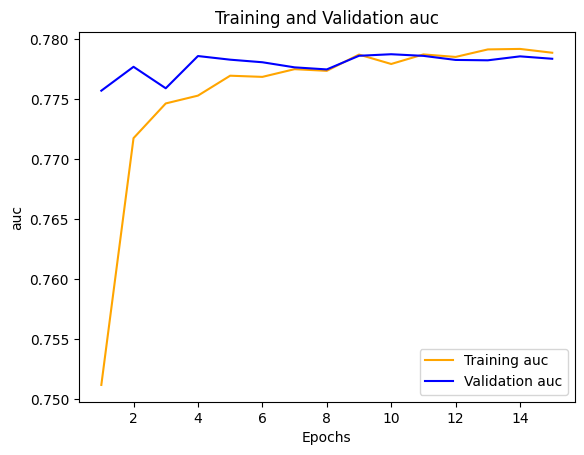

In [43]:
# Метрика похуже первоначального значения, но нет переобучения
show_best_metric(history, 'auc')
show_best_metric(history, 'accuracy')
show_best_metric(history, 'precision')

check_metrics(history, 'auc')

Я поэкспериментировал с разными архитектурами, самая наивная модель с архитектурой 16-16-16-1 получилась самой лучшей по метрике auc -- 0,7855, но она переобученная. Та же самая модель с BatchNormalization() и Dropout() не улучшает метрику, но уменьшает переобученность. Последняя модель выше получилась неплохая, из графика видно, что она не переобучается. Ниже я перебрал ещё около десятка разных архитектур. Глобально val_auc почти всегда у регуляризованных моделей лежит в диапазоне 0,77 -- 0,78, поэтому здесь лучше сделать акцент на непереобученности. Я оставил только наиболее непереобученные варианты.

Глобальные выводы таковы:

1. Малоскоррелированные с таргетом фичи и часть сильно скоррелированных между собой фич можно смело удалять -- val_auc от этого практически не меняется (уменьшается примерно на 0,8%), но по виду графика модель становится более устойчивой и переобучение становится немного меньше.

2. Добавление новых фич требует отдельного исследования, наивная попытка добавить квадраты/кубы оставшихся фич либо не улучшило метрики, либо сильно ухудшило.

3. BatchNormalization() и Dropout() не помогли увеличить auc, но позволили снизить переобученность.

In [44]:
def create_model_regg(features_train):
    
    model = Sequential()
    model.add(Input(shape=(features_train.shape[1],)))
    
    model.add(Dense(128, activation='relu'))    # Далее соответственно число нейронов и функция активации
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'auc']
                  )
    return model

In [45]:
model = create_model_regg(features_train_reduced)

N = 100

early_stopping = EarlyStopping(monitor='val_auc', patience=5)
save_best_weights = ModelCheckpoint(filepath='./Best_auc_2.weights.h5',
                                    save_weights_only=True,
                                    monitor='val_auc',
                                    mode='max',
                                    save_best_only=True)

history = model.fit(features_train_reduced, target_train,
           validation_data=(features_test_reduced, target_test),
           epochs=N,
           batch_size=128,
           class_weight = {0: class_weights[0], 1: class_weights[1]},
           callbacks=[early_stopping, save_best_weights]
           )

Epoch 1/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7061 - auc: 0.7449 - loss: 0.6138 - precision: 0.4086 - val_accuracy: 0.7060 - val_auc: 0.7768 - val_loss: 0.5800 - val_precision: 0.4145
Epoch 2/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7301 - auc: 0.7718 - loss: 0.5754 - precision: 0.4388 - val_accuracy: 0.7322 - val_auc: 0.7776 - val_loss: 0.5570 - val_precision: 0.4407
Epoch 3/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7363 - auc: 0.7747 - loss: 0.5686 - precision: 0.4437 - val_accuracy: 0.7219 - val_auc: 0.7776 - val_loss: 0.5662 - val_precision: 0.4297
Epoch 4/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7330 - auc: 0.7769 - loss: 0.5660 - precision: 0.4401 - val_accuracy: 0.7222 - val_auc: 0.7780 - val_loss: 0.5694 - val_precision: 0.4300
Epoch 5/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7303 - auc: 0.7771 - loss: 0.5692 - precision: 0.4421 - val_accuracy: 0.7191 - val_auc: 0.7772 - val_loss: 0.5668

,auc,val_auc
22,0.7810,0.7801


,accuracy,val_accuracy
22,0.7328,0.7470


,precision,val_precision
22,0.4427,0.4587


/tmp/ipykernel_17275/2180351603.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


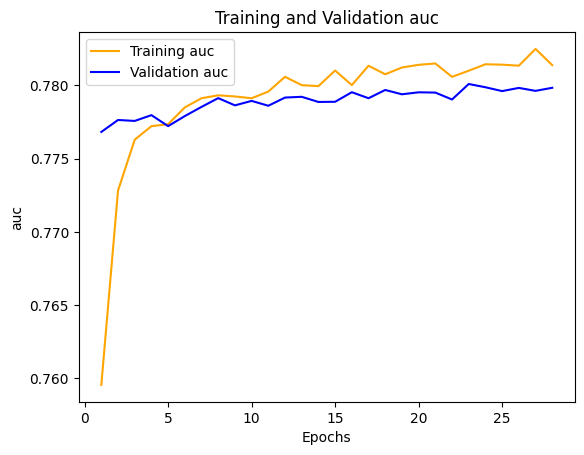

In [46]:
show_best_metric(history, 'auc')
show_best_metric(history, 'accuracy')
show_best_metric(history, 'precision')

check_metrics(history, 'auc')

In [47]:
def create_model_reggg(features_train):
    
    model = Sequential()
    model.add(Input(shape=(features_train.shape[1],)))
    
    model.add(Dense(64, activation='relu'))    # Далее соответственно число нейронов и функция активации
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'auc']
                  )
    return model
model = create_model_reggg(features_train_reduced)

N = 100

early_stopping = EarlyStopping(monitor='val_auc', patience=5)
save_best_weights = ModelCheckpoint(filepath='./Best_auc_3.weights.h5',
                                    save_weights_only=True,
                                    monitor='val_auc',
                                    mode='max',
                                    save_best_only=True)

history = model.fit(features_train_reduced, target_train,
           validation_data=(features_test_reduced, target_test),
           epochs=N,
           batch_size=128,
           class_weight = {0: class_weights[0], 1: class_weights[1]},
           callbacks=[early_stopping, save_best_weights]
           )

Epoch 1/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6864 - auc: 0.7363 - loss: 0.6254 - precision: 0.3923 - val_accuracy: 0.7155 - val_auc: 0.7769 - val_loss: 0.5784 - val_precision: 0.4233
Epoch 2/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7178 - auc: 0.7693 - loss: 0.5784 - precision: 0.4278 - val_accuracy: 0.7341 - val_auc: 0.7776 - val_loss: 0.5542 - val_precision: 0.4428
Epoch 3/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7268 - auc: 0.7751 - loss: 0.5691 - precision: 0.4348 - val_accuracy: 0.7209 - val_auc: 0.7770 - val_loss: 0.5640 - val_precision: 0.4290
Epoch 4/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7280 - auc: 0.7760 - loss: 0.5714 - precision: 0.4407 - val_accuracy: 0.7410 - val_auc: 0.7780 - val_loss: 0.5572 - val_precision: 0.4510
Epoch 5/100
637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7320 - auc: 0.7745 - loss: 0.5705 - precision: 0.4422 - val_accuracy: 0.7209 - val_auc: 0.7779 - val_loss: 0.5750

,auc,val_auc
10,0.7793,0.7793


,accuracy,val_accuracy
5,0.7322,0.7452


,precision,val_precision
5,0.4419,0.4563


/tmp/ipykernel_17275/2180351603.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


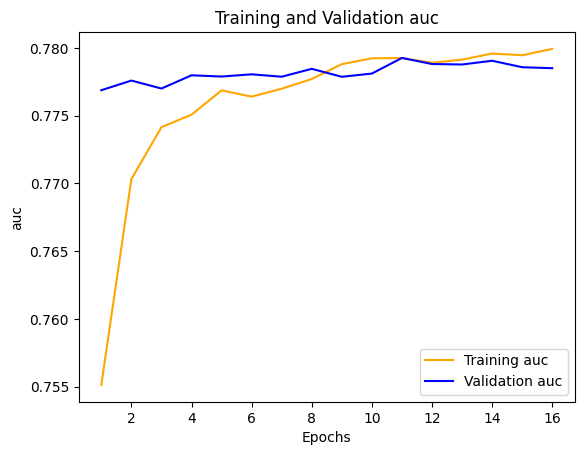

In [48]:
show_best_metric(history, 'auc')
show_best_metric(history, 'accuracy')
show_best_metric(history, 'precision')

check_metrics(history, 'auc')